In [5]:
import pandas as pd
import numpy as np
import psycopg2

db_navn = 'AC Horsens'
db_brugernavn = 'postgres'
db_adgangskode = 'ACHorsens'
db_host = 'localhost'
conn = psycopg2.connect(
    dbname=db_navn,
    user=db_brugernavn,
    password=db_adgangskode,
    host=db_host
)

cur = conn.cursor()
cur.execute("SELECT schema_name FROM information_schema.schemata")
schemas = cur.fetchall()
print('connected to database')
def map_to_unified_columns_possession(df):
    # Create a dictionary mapping the original column names to the unified column names
    column_mapping = {
        'contestantId': 'contestantId',
        'team_name': 'team_name',
        'id': 'id',
        'eventId': 'eventId',
        'typeId': 'typeId',
        'periodId': 'periodId',
        'timeMin': 'timeMin',
        'timeSec': 'timeSec',
        'outcome': 'outcome',
        'x': 'x',
        'y': 'y',
        'timeStamp': 'timeStamp',
        'lastModified': 'lastModified',
        'playerId': 'playerId',
        'playerName': 'playerName',
        'sequenceId': 'sequenceId',
        'possessionId': 'possessionId',
        'keyPass': 'keyPass',
        'assist': 'assist',
        '2.0' : '2.0',
        '140.0': '140.0',
        '141.0': '141.0',
        '318.0': '318.0',
        '321.0': '321.0',
        '210.0': '210',
        '22.0': '22.0',
        '23.0': '23.0',
        '5.0' : '5.0',
        '6.0' : '6.0',
        '9.0' : '9.0',
        '24.0': '24.0',
        '25.0': '25.0',
        '26.0': '26.0',
        '107.0':'107.0',
        '210.0':'210.0',
        '213.0':'213.0',
        'match_id': 'match_id',
        'label': 'label',
        'date': 'date',
    }
    for col in column_mapping.values():
        if col not in df.columns:
            df[col] = None

    # Rename columns using the mapping dictionary
    unified_df = df.rename(columns=column_mapping)

    return unified_df

from concurrent.futures import ThreadPoolExecutor
import psycopg2
import pandas as pd
import io
from psycopg2 import sql

def fast_table_to_df(cur, schema, table):
    query = sql.SQL('COPY {}.{} TO STDOUT WITH CSV HEADER').format(
        sql.Identifier(schema),
        sql.Identifier(table)
    )
    buffer = io.StringIO()
    cur.copy_expert(query, buffer)
    buffer.seek(0)
    return pd.read_csv(buffer)

def process_schema(schema):
    local_conn = psycopg2.connect(
        dbname=db_navn,
        user=db_brugernavn,
        password=db_adgangskode,
        host=db_host,
        port="5432"
    )
    local_cur = local_conn.cursor()

    result_dfs = []
    try:
        local_cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = %s", (schema,))
        tables = [t[0] for t in local_cur.fetchall() if 'possession_data' in t[0]]

        for table in tables:
            print(f"Processing {schema}.{table}")
            df = fast_table_to_df(local_cur, schema, table)
            df = map_to_unified_columns_possession(df)
            df = df[['timeMin', 'timeSec', 'x', 'y','team_name', 'playerName', 'label','date','typeId','outcome','2.0','6.0','sequence_xG','140.0','141.0','318.0','321.0', '322.0','receiverName']]
            result_dfs.append(df)
    except Exception as e:
        print(f"Error processing {schema}: {e}")
    finally:
        local_cur.close()
        local_conn.close()

    return result_dfs

schemas_to_include = [
    #'DNK_1_Division_2023_2024',
    #'DNK_1_Division_2024_2025',
    'DNK_1_Division_2025_2026',
    #'SRB_Super_Liga_2023_2024',
    #'SRB_Super_Liga_2024_2025',
    #'SRB_Super_Liga_2025_2026',
    #'DNK_Superliga_2024_2025'
]

with ThreadPoolExecutor(max_workers=4) as executor:
    results = list(executor.map(process_schema, schemas_to_include))

# Flatten and combine
all_data_frames = [df for dfs in results for df in dfs]
combined_df = pd.concat(all_data_frames, ignore_index=True)


connected to database
Processing DNK_1_Division_2025_2026.HB_Køge_vs_Hobro2025_07_18possession_data
Processing DNK_1_Division_2025_2026.Hvidovre_vs_B_932025_07_18possession_data
Processing DNK_1_Division_2025_2026.Kolding_vs_AaB2025_07_19possession_data
Processing DNK_1_Division_2025_2026.Hillerød_vs_Middelfart2025_07_19possession_data
Processing DNK_1_Division_2025_2026.Horsens_vs_Aarhus_Fremad2025_07_19possession_data
Processing DNK_1_Division_2025_2026.Esbjerg_vs_Lyngby2025_07_20possession_data
Processing DNK_1_Division_2025_2026.HB_Køge_vs_Aarhus_Fremad2025_07_25possession_data
Processing DNK_1_Division_2025_2026.Horsens_vs_Kolding2025_07_25possession_data
Processing DNK_1_Division_2025_2026.Lyngby_vs_B_932025_07_25possession_data
Processing DNK_1_Division_2025_2026.Hillerød_vs_AaB2025_07_26possession_data
Processing DNK_1_Division_2025_2026.Esbjerg_vs_Hvidovre2025_07_26possession_data
Processing DNK_1_Division_2025_2026.Hobro_vs_Middelfart2025_07_27possession_data


In [6]:
combined_df = combined_df[combined_df['team_name'] == 'Hvidovre']
combined_df = combined_df[combined_df['typeId'] == 1]
combined_df = combined_df[combined_df['2.0'].notna()]
combined_df = combined_df[~combined_df['6.0'].isin([True, 'true'])]

combined_df['318.0'] = pd.to_numeric(combined_df['318.0'], errors='coerce')

players = combined_df.value_counts('playerName')
receivers = combined_df.value_counts('receiverName')
xa = combined_df.groupby('playerName', as_index=True)['318.0'].sum()
xa = xa.sort_values(ascending=False)
print(players)
print(receivers)
print(xa)

playerName
A. Iljazovski     11
N. Clausen         6
A. Smed            4
J. Singh           4
O. Kjærgaard       3
A. Johansen        2
D. Stenderup       2
F. Krogstad        1
J. Adjei-Broni     1
Name: count, dtype: int64
receiverName
M. Egho         3
E. Aby          2
F. Høgh         2
J. Singh        2
N. Jungvig      2
D. Stenderup    1
M. Knudsen      1
Name: count, dtype: int64
playerName
A. Iljazovski     0.546108
O. Kjærgaard      0.229645
J. Singh          0.193818
A. Smed           0.156739
N. Clausen        0.105782
D. Stenderup      0.041753
A. Johansen       0.000000
F. Krogstad       0.000000
J. Adjei-Broni    0.000000
Name: 318.0, dtype: float64


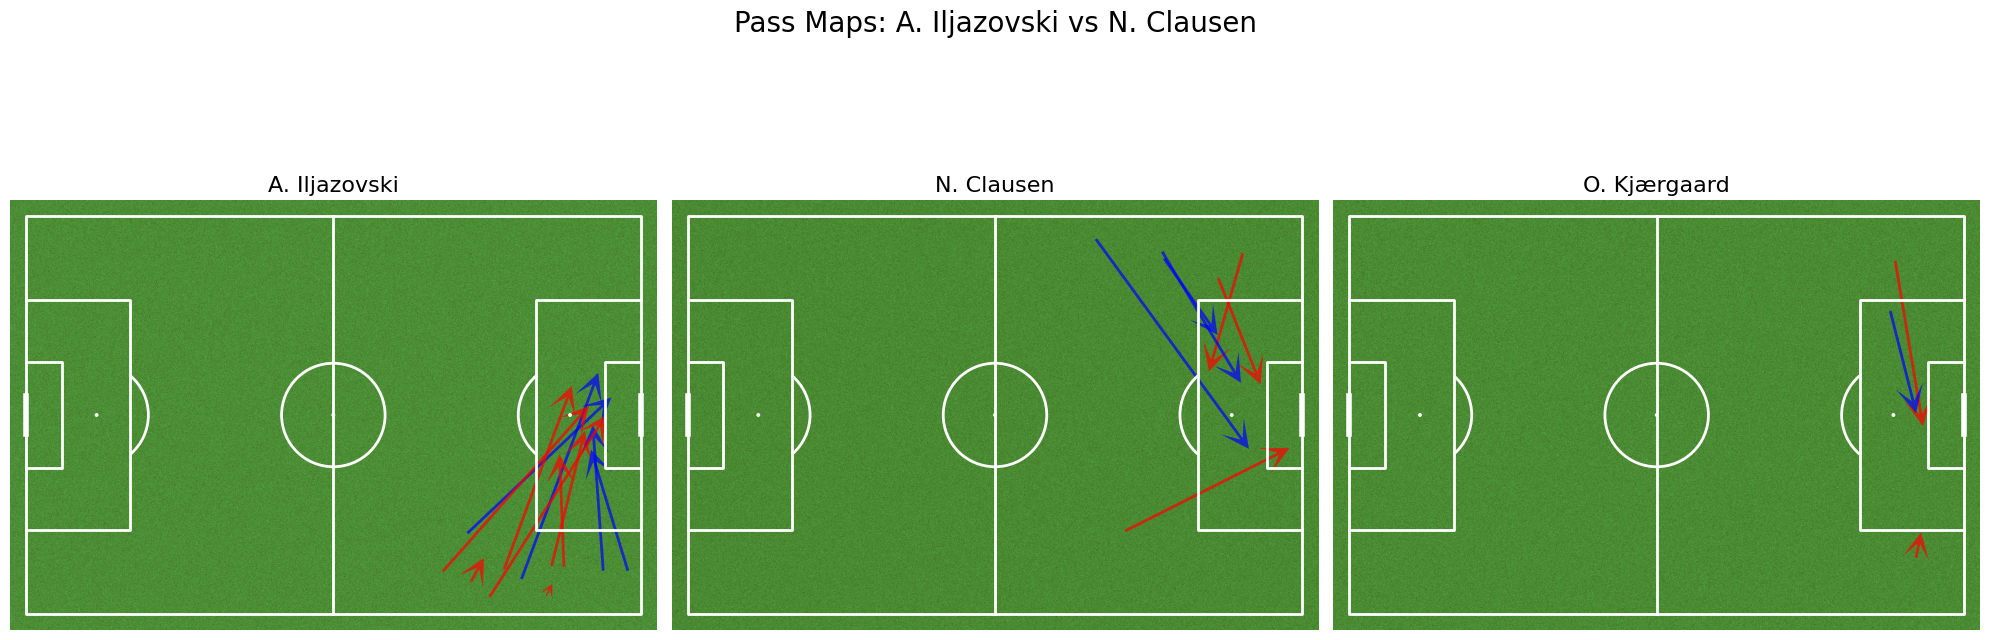

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Create pitch object
pitch = Pitch(pitch_type='opta', pitch_color='grass', line_color='white', line_zorder=2)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('Pass Maps: A. Iljazovski vs N. Clausen', fontsize=20)

# Define players to plot
players = ['A. Iljazovski', 'N. Clausen','O. Kjærgaard']

# Loop through each player and axis
for ax, player in zip(axes, players):
    pitch.draw(ax=ax)
    player_df = combined_df[combined_df['playerName'] == player]

    for _, row in player_df.iterrows():
        color = 'red' if row['outcome'] == 0 else 'blue'
        
        pitch.arrows(
            xstart=row['x'],
            ystart=row['y'],
            xend=row['140.0'],
            yend=row['141.0'],
            ax=ax,
            color=color,
            width=2,
            headwidth=10,
            headlength=10,
            alpha=0.7
        )

    ax.set_title(player, fontsize=16)

plt.tight_layout()
plt.show()